In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Loading Data
Data = np.load("ex5data.npz")
Data.files

['ytest', 'yval', 'Xtest', 'Xval', 'y', 'X']

### ex5data.npz  
This dataset is divided into three parts  
  * A training set that your model will learn on: X, y
  * A cross validation set for determining the regularization parameter: Xval, yval
  * A test set for evaluating performance. These are “unseen” examples which your model did not see during training: Xtest, ytest

The aim is to implement regularized regression to predict the amount of water flowing out of a dam **(y)** ,
using the change of water level in a reservoir **(X)** .  
The other part deals with some diagnostics of debugging learning algorithms and examining the effects of **Bias vs Variance** . 


In [3]:
X = Data['X']
y = Data['y']
Xtest = Data['Xtest']
ytest = Data['ytest']
Xval = Data['Xval']
yval = Data['yval']
m = X.shape[0]
n = X.shape[1]+1

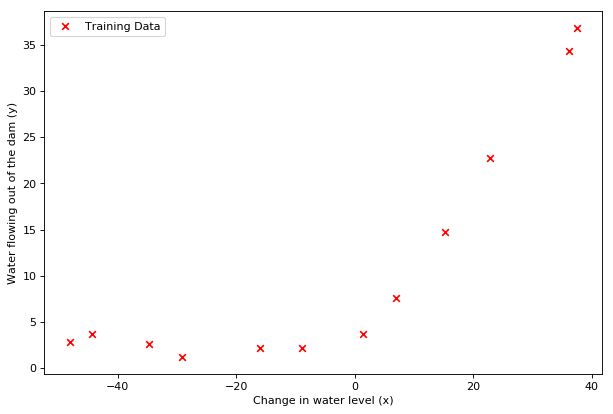

In [4]:
# Plotting Training Data
plt.figure(figsize = (9,6),dpi = 80)
plt.scatter(X,y,c ='r', marker='x',label = "Training Data")
plt.legend(loc = 'upper left')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.show()

In [5]:
# Cost Function and Gradient for Regularized Regression
def costFunction(theta,X,y,lamb):
    m = y.size
    X_append = np.c_[np.ones(m),X]
    cost = (1.0/(2*m))*(np.sum((X_append.dot(theta) - y) **2) + lamb * sum(theta[1:]**2))
    
    grad = (1.0/m)*(X_append.T).dot((X_append.dot(theta)-y))
    grad[1:] += (lamb/float(m))* theta[1:] 
    
    return cost,grad

In [6]:
# Computing Cost and Gradient values for Theta = [1,1]
t_temp = np.array([1,1])
cost,grad = costFunction(t_temp,X,y,1)
print cost
print grad

303.9931922202643
[-15.30301567 598.25074417]


In [7]:
# Optimizing the parameters theta using scipy.optimize 
def find_min(init_theta,par):
    res = minimize(costFunction,init_theta,args=(par),method = 'CG',jac = True
               ,options={'maxiter':75,'disp':True})  
    return res.x

In [8]:
# Function for computing training and cross validation erros required for Learning Curves
def learningCurves(X,y,Xval,yval,lamb):
    m,n = X.shape
    train_error = np.empty(m)
    val_error = np.empty(m)
    for i in range(1,m+1):
        init_theta = np.zeros(n+1)
        X_train = X[:i,:]
        y_train = y[:i]
        par1 = X_train,y_train,lamb
        theta_temp = find_min(init_theta,par1)
        train_error[i-1] = costFunction(theta_temp,X_train,y_train,0)[0]
        val_error[i-1] = costFunction(theta_temp,Xval,yval,0)[0]
        
    return train_error,val_error   

In [9]:
# Train linear regression with lambda = 0
# The data is non-linear, so this will not give a great fit
init_t = np.zeros(n)
lamb = 0
par = X,y,lamb
f_theta1 = find_min(init_t,par)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


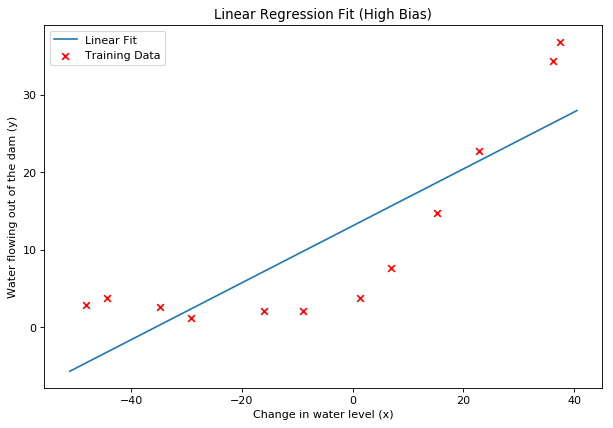

In [10]:
# Prediction value at (X_max +3) and (X_min -3) and Plotting with Linear Fit
val1 = np.array([1,X.max() +3]).dot(f_theta1)
val2 = np.array([1,X.min() -3]).dot(f_theta1)
plt.figure(figsize = (9,6),dpi = 80)
plt.scatter(X,y,c ='r', marker='x',label = "Training Data")
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.plot([X.max()+3,X.min()-3],[val1,val2],label = 'Linear Fit')
plt.legend(loc = 'upper left')
plt.title('Linear Regression Fit (High Bias)')
plt.show()

In [11]:
# Fetching values of train and CV errors for Linear Fit required for Learning Curves
e_t1,e_val1 = learningCurves(X,y,Xval,yval,lamb)
print "\n   Training Error   Cross Validation Error"
print np.c_[e_t1,e_val1]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 3.286595
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 2.842678
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.154049
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 19.443963
         Iterations: 22
         Function evaluations: 34
        

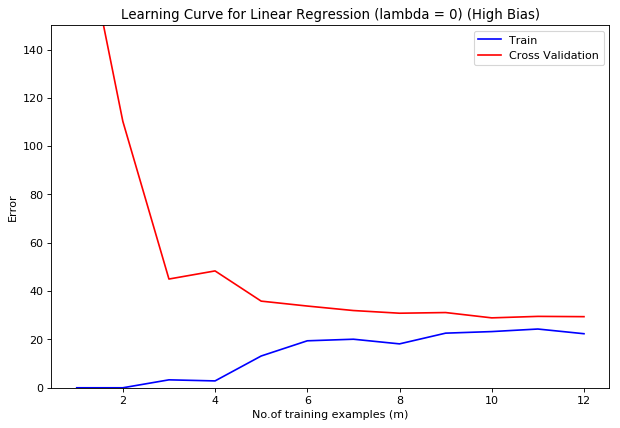

In [12]:
# PLotting the Learning Curves for Linear Fit
plt.figure(figsize = (9,6),dpi = 80)
plt.plot(np.arange(1,m+1),e_t1,c='b',label='Train')
plt.plot(np.arange(1,m+1),e_val1,c='r',label='Cross Validation')
plt.legend()
plt.xlabel('No.of training examples (m)')
plt.ylabel('Error')
plt.title('Learning Curve for Linear Regression (lambda = 0) (High Bias)')
plt.ylim(ymin=0,ymax =150)
plt.show()

In [13]:
# Feature Mapping for Polynomial Regression
def polyFeatures(X,p):
    m = X.shape[0]
    X_poly = np.zeros((m,p))
    for i in range(1,p+1):
        X_poly[:,i-1] = (X.flatten())**i
        
    return X_poly

In [14]:
# Mapping train, cv and test set to polynomial features
p = 8
X_p = polyFeatures(X,p)
X_pval = polyFeatures(Xval,p)
X_ptest = polyFeatures(Xtest,p)

In [15]:
# Calculating the mean and standard deviation and performing Feature Normalization
mu = np.mean(X_p,axis = 0)
sigma = np.std(X_p,axis = 0)
X_p = np.apply_along_axis(np.subtract,1,X_p,mu)
X_p = np.apply_along_axis(np.divide,1,X_p,sigma)
X_pval = np.apply_along_axis(np.subtract,1,X_pval,mu)
X_pval = np.apply_along_axis(np.divide,1,X_pval,sigma)
X_ptest = np.apply_along_axis(np.subtract,1,X_ptest,mu)
X_ptest = np.apply_along_axis(np.divide,1,X_ptest,sigma)

In [16]:
# Fetching values of range to plot the polynomial fit
xr = np.arange(round(X.min()-15),round(X.max()+15),0.5)
xr_poly = polyFeatures(xr,p)
xr_poly = np.apply_along_axis(np.subtract,1,xr_poly,mu)
xr_poly = np.apply_along_axis(np.divide,1,xr_poly,sigma)
xr_poly = np.c_[np.ones(xr_poly.shape[0]),xr_poly]

In [17]:
# Training Polynomial Regression with lambda = 0
init_t = np.zeros(p+1)
lamb = 0
par = X_p,y,lamb
f_theta2 = find_min(init_t,par)

         Current function value: 0.204942
         Iterations: 75
         Function evaluations: 136
         Gradient evaluations: 136


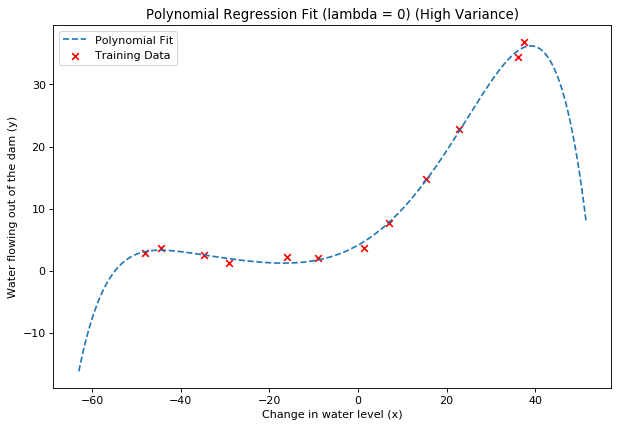

In [18]:
# Plotting the Polynomial Fit
plt.figure(figsize = (9,6),dpi = 80)
plt.scatter(X,y,c ='r', marker='x',label = "Training Data")
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title('Polynomial Regression Fit (lambda = 0) (High Variance)')
plt.plot(xr,xr_poly.dot(f_theta2),linestyle=('--'),label = 'Polynomial Fit')
plt.legend(loc = 'upper left')
plt.show()

In [19]:
# Fetching values of train and CV errors required for the Learning Curve
e_t2,e_val2 = learningCurves(X_p,y,X_pval,yval,lamb)
print "\n   Training Error   Cross Validation Error"
print np.c_[e_t2,e_val2]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 70
         

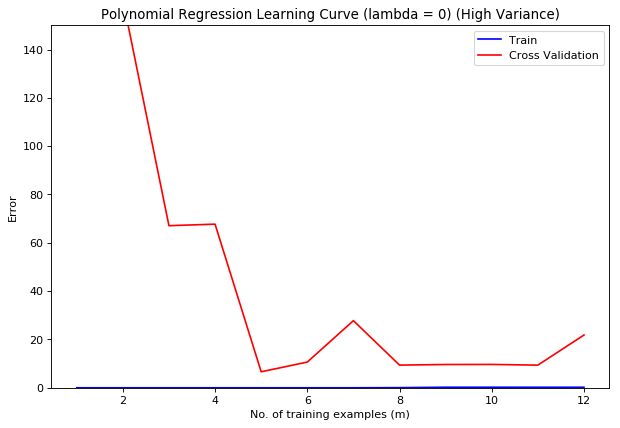

In [20]:
# PLotting the Learning Curves for Polynomial Fit with lambda = 0
plt.figure(figsize = (9,6),dpi = 80)
plt.plot(np.arange(1,m+1),e_t2,c='b',label='Train')
plt.plot(np.arange(1,m+1),e_val2,c='r',label='Cross Validation')
plt.ylim(ymin=0,ymax =150)
plt.legend()
plt.ylabel('Error')
plt.xlabel('No. of training examples (m)')
plt.title('Polynomial Regression Learning Curve (lambda = 0) (High Variance)')
plt.show()

In [21]:
# Function for computing training and CV erros with differnt lambda required for the Validation Curve
def validationCurve(X,y,Xval,yval):
    lamb_vec = np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10])
    error_train = np.empty(lamb_vec.size)
    error_val = np.empty(lamb_vec.size)
    for i in range(lamb_vec.size):
        init_theta = np.zeros(X.shape[1]+1)
        par = X,y,lamb_vec[i]
        theta = find_min(init_theta,par)
        error_train[i] = costFunction(theta,X,y,0)[0]
        error_val[i] = costFunction(theta,Xval,yval,0)[0]
    
    return lamb_vec, error_train, error_val

In [22]:
# Fetching values of train and CV errors for different values of lambda
lamb_vec,e_t3,e_val3 = validationCurve(X_p,y,X_pval,yval)
print "\n     Lambda          Training Error   Cross Validation Error"
print np.c_[lamb_vec,e_t3,e_val3]

         Current function value: 0.204942
         Iterations: 75
         Function evaluations: 136
         Gradient evaluations: 136
         Current function value: 0.217730
         Iterations: 75
         Function evaluations: 140
         Gradient evaluations: 140
         Current function value: 0.243201
         Iterations: 75
         Function evaluations: 154
         Gradient evaluations: 154
         Current function value: 0.371665
         Iterations: 75
         Function evaluations: 144
         Gradient evaluations: 144
         Current function value: 0.636711
         Iterations: 75
         Function evaluations: 131
         Gradient evaluations: 131
         Current function value: 1.360572
         Iterations: 75
         Function evaluations: 140
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: 2.917649
         Iterations: 53
         Function evaluations: 89
         Gradient evaluations: 89
Optimization

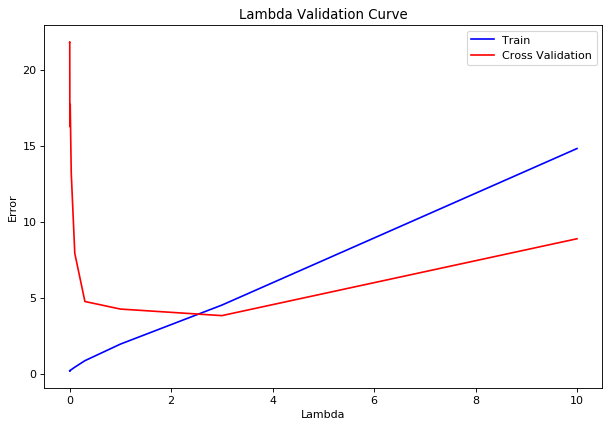

In [23]:
# Plottingn Lambda Validation Curve
plt.figure(figsize = (9,6),dpi = 80)
plt.plot(lamb_vec,e_t3,c='b',label='Train')
plt.plot(lamb_vec,e_val3,c='r',label ='Cross Validation')
plt.legend()
plt.title('Lambda Validation Curve')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.show()

Best choice of lambda from the validation curve : lambda = 3.0 

Optimization terminated successfully.
         Current function value: 14.937646
         Iterations: 13
         Function evaluations: 24
         Gradient evaluations: 24


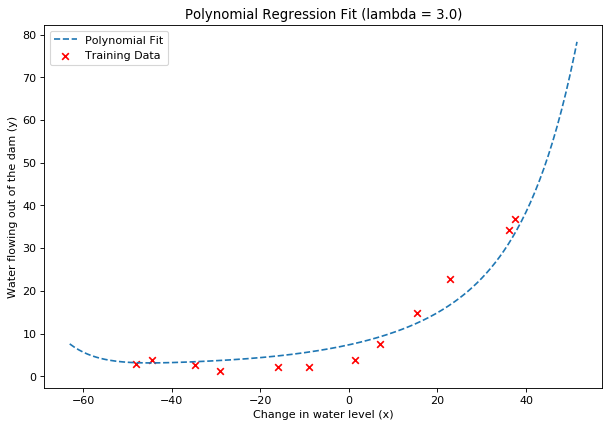

In [24]:
# Finding the best choice for lamda and plotting the polynomial fit
index = np.argmin(e_val3)
lamb = lamb_vec[index]
print "Best choice of lambda from the validation curve : lambda = %s" %lamb ,"\n"
par = X_p,y,lamb
f_theta3 = find_min(init_t,par)
plt.figure(figsize = (9,6),dpi = 80)
plt.scatter(X,y,c ='r', marker='x',label = "Training Data")
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title('Polynomial Regression Fit (lambda = %s)' %lamb)
plt.plot(xr,xr_poly.dot(f_theta3),linestyle=('--'),label = 'Polynomial Fit')
plt.legend(loc = 'upper left')
plt.show()

In [25]:
# Fetching values of train and CV errors for the best choice lambda requied for the Learning Curves
er_t,er_val = learningCurves(X_p,y,X_pval,yval,lamb)
print "\n   Training Error   Cross Validation Error"
print np.c_[er_t,er_val]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.095110
         Iterations: 7
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 39.939109
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 34.026343
         Iterations: 16
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 27.239317
         Iterations: 24
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 24.085480
         Iterations: 22
         Function evaluations: 39


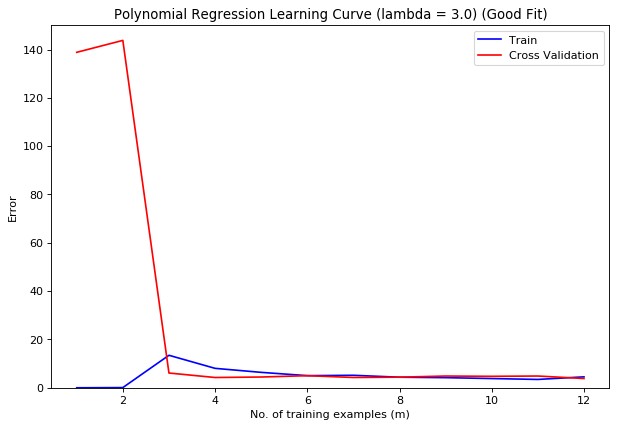

In [26]:
# PLotting the Learning Curves for Polynomial Fit with best choice lambda
plt.figure(figsize = (9,6),dpi = 80)
plt.plot(np.arange(1,m+1),er_t,c='b',label='Train')
plt.plot(np.arange(1,m+1),er_val,c='r',label='Cross Validation')
plt.ylim(ymin=0,ymax =150)
plt.legend()
plt.xlabel('No. of training examples (m)')
plt.ylabel('Error')
plt.title('Polynomial Regression Learning Curve (lambda = %s) (Good Fit)' %lamb)
plt.show() 

In [27]:
# Train, CV and Test errors
error_test = costFunction(f_theta3,X_ptest,ytest,0)[0]
error_train = costFunction(f_theta3,X_p,y,0)[0]
error_val = costFunction(f_theta3,X_pval,yval,0)[0]
print "Error on the Training Set:", round(error_train,2)
print "Error on the Cross Validation Set:", round(error_val,2)
print"Error on the Test Set:", round(error_test,2)

Error on the Training Set: 4.53
Error on the Cross Validation Set: 3.83
Error on the Test Set: 3.57
